In [1]:
# !pip install -q "transformers>=4.56.0" "accelerate" "scikit-learn"

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import networkx as nx
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets
from sklearn.metrics.pairwise import cosine_similarity


2025-12-24 01:42:25.560014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766540545.754763      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766540545.813489      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766540546.287635      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766540546.287672      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766540546.287675      55 computation_placer.cc:177] computation placer alr

In [ ]:
from huggingface_hub import login

login("<your_token>", add_to_git_credential=False)

In [4]:
"""
Unsupervised Object Discovery using DINOv3 and TokenCut
Improved implementation with proper feature extraction and post-processing
"""

import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from typing import Tuple, List, Optional
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing

try:
    from torchvision.datasets import VOCDetection, CocoDetection
except ImportError:
    print("Installing required packages...")
    os.system("pip install torch torchvision transformers pillow scipy numpy matplotlib tqdm")
    from torchvision.datasets import VOCDetection, CocoDetection


class TokenCut: 
    """
    Improved TokenCut algorithm for unsupervised object discovery
    """
    
    def __init__(self, threshold: float = 0.2, eps: float = 1e-5):
        self.threshold = threshold
        self. eps = eps
    
    def compute_affinity_matrix(self, features: torch. Tensor) -> np.ndarray:
        """
        Compute affinity matrix based on cosine similarity between patch features
        """
        # Normalize features (L2 normalization)
        features_norm = F.normalize(features, dim=1, p=2)
        
        # Compute cosine similarity
        affinity = features_norm @ features_norm.T
        
        # Ensure numerical stability
        affinity = torch.clamp(affinity, -1.0, 1.0)
        
        return affinity. cpu().numpy()
    
    def get_salient_patches(self, affinity:  np.ndarray, percentile:  float = 20) -> np.ndarray:
        """
        Identify salient patches based on affinity statistics
        This helps focus on foreground objects
        """
        # Compute mean affinity for each patch (excluding self)
        np.fill_diagonal(affinity, 0)
        mean_affinity = affinity.mean(axis=1)
        
        # Patches with lower mean affinity are more distinct (likely foreground)
        threshold = np.percentile(mean_affinity, percentile)
        salient_mask = mean_affinity <= threshold
        
        return salient_mask
    
    def spectral_clustering(self, affinity: np.ndarray, tau: float = 0.2) -> np.ndarray:
        """
        Apply spectral clustering using normalized cuts
        """
        # Threshold affinity matrix
        affinity_thresh = (affinity > tau).astype(float)
        
        # Add self-connections
        np.fill_diagonal(affinity_thresh, 1.0)
        
        # Compute degree matrix
        degree = np.sum(affinity_thresh, axis=1)
        degree = np.maximum(degree, self.eps)  # Avoid division by zero
        
        # Create sparse matrices
        D = sp.diags(degree)
        A = sp.csr_matrix(affinity_thresh)
        
        # Normalized Laplacian:  L = D^(-1/2) * A * D^(-1/2)
        D_inv_sqrt = sp.diags(1.0 / np.sqrt(degree))
        L = D_inv_sqrt @ A @ D_inv_sqrt
        
        # Compute eigenvectors
        try:
            # Get top 2 eigenvectors
            eigenvalues, eigenvectors = eigsh(L, k=2, which='LA')
            # Second eigenvector (first is trivial constant vector)
            second_eigenvector = eigenvectors[:, 0]
        except:
            # Fallback to dense computation
            L_dense = L.toarray()
            eigenvalues, eigenvectors = np.linalg.eigh(L_dense)
            second_eigenvector = eigenvectors[:, -2]
        
        return second_eigenvector
    
    def get_mask_from_eigenvector(self, eigenvector: np.ndarray, grid_shape: Tuple[int, int], 
                                   use_adaptive: bool = True) -> np.ndarray:
        """
        Convert eigenvector to binary mask
        """
        if use_adaptive:
            # Try both above and below median, choose better one
            median = np.median(eigenvector)
            mask1 = (eigenvector > median).astype(float)
            mask2 = (eigenvector <= median).astype(float)
            
            # Choose the mask with smaller area (more likely to be object)
            mask = mask1 if mask1.sum() < mask2.sum() else mask2
        else:
            # Simple median thresholding
            threshold = np.median(eigenvector)
            mask = (eigenvector > threshold).astype(float)
        
        # Reshape to grid
        mask = mask. reshape(grid_shape)
        
        return mask
    
    def post_process_mask(self, mask: np.ndarray) -> np.ndarray:
        """
        Post-process mask to remove noise and fill holes
        """
        # Fill holes
        mask_filled = binary_fill_holes(mask > 0.5)
        
        # Morphological operations
        mask_cleaned = binary_closing(mask_filled, structure=np.ones((3, 3)))
        mask_cleaned = binary_opening(mask_cleaned, structure=np.ones((2, 2)))
        
        return mask_cleaned. astype(float)
    
    def extract_object_mask(self, features: torch.Tensor, grid_shape: Tuple[int, int],
                           use_saliency: bool = False, use_adaptive: bool = True,
                           post_process: bool = True) -> np.ndarray:
        """
        Extract object mask from features using TokenCut
        """
        # Compute affinity matrix
        affinity = self.compute_affinity_matrix(features)
        
        # Optional: focus on salient patches
        if use_saliency:
            salient_mask = self.get_salient_patches(affinity)
            # Could use this to weight the affinity, but for simplicity we skip
        
        # Apply spectral clustering
        eigenvector = self.spectral_clustering(affinity, tau=self.threshold)
        
        # Convert to mask
        mask = self. get_mask_from_eigenvector(eigenvector, grid_shape, use_adaptive=use_adaptive)
        
        # Post-process
        if post_process:
            mask = self.post_process_mask(mask)
        
        return mask


class DINOv3ObjectDiscovery:
    """
    Main class for unsupervised object discovery using DINOv3
    """
    
    def __init__(self, model_name: str = "facebook/dinov2-base", device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        """
        Initialize with a vision transformer model from HuggingFace
        
        Note: As of now, DINOv3 might not be available on HuggingFace yet. 
        Using DINOv2 as the closest available model.
        """
        self.device = device
        self.model_name = model_name
        
        print(f"Loading model:  {model_name}")
        from transformers import AutoModel, AutoImageProcessor
        
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.processor = AutoImageProcessor.from_pretrained(model_name)

        self.model.eval()
        self.reg_count = self.model.config.num_register_tokens if hasattr(self.model. config, 'num_register_tokens') else 0
        
        # Get patch size
        self.patch_size = self.model.config.patch_size if hasattr(self.model. config, 'patch_size') else 14
        print(self.model.config)
        print(f"Model loaded on {device} with patch size {self.patch_size}, reg count {self.reg_count}")
    
    def preprocess_image(self, image:  Image.Image, size: int = 518) -> torch.Tensor:
        """
        Preprocess image with proper resizing
        DINOv2 works best with resolution 518x518
        """
        # Resize while maintaining aspect ratio
        w, h = image.size
        scale = size / min(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        
        # Make dimensions divisible by patch_size
        new_w = (new_w // self.patch_size) * self.patch_size
        new_h = (new_h // self.patch_size) * self.patch_size
        
        image_resized = image.resize((new_w, new_h), Image.BICUBIC)
        
        inputs = self.processor(images=image_resized, return_tensors="pt")
        return inputs['pixel_values'].to(self.device), image_resized
    
    def extract_features(self, image:  Image.Image, layer: int = -1) -> Tuple[torch.Tensor, Tuple[int, int], Image.Image]:
        """
        Extract patch features from image
        
        Args:
            image: PIL Image
            layer: Which layer to extract features from (-1 = last, -2 = second to last, etc.)
        
        Returns:
            features: Tensor of shape (num_patches, feature_dim)
            grid_shape: (height, width) of patch grid
            processed_image: The resized image
        """
        # Preprocess
        pixel_values, processed_image = self.preprocess_image(image)
        
        # Extract features
        with torch.no_grad():
            outputs = self.model(pixel_values, output_hidden_states=True)
            
            # Access hidden states
            if layer == -1:
                # Last layer output features
                features = outputs.last_hidden_state[0, 1 + self.reg_count: , :]  # Remove CLS token
            else:
                # Access specific layer
                features = outputs. hidden_states[layer][0, 1 + self.reg_count:, :]
        
        # Compute grid shape
        h, w = pixel_values.shape[2], pixel_values.shape[3]
        grid_h = h // self.patch_size
        grid_w = w // self. patch_size
        
        return features, (grid_h, grid_w), processed_image
    
    def discover_objects(self, image: Image.Image, threshold: float = 0.2, 
                        use_adaptive: bool = True, post_process: bool = True,
                        visualize: bool = True, layer: int = -1) -> Tuple[np.ndarray, Image.Image]:
        """
        Discover objects in image using TokenCut
        """
        # Extract features
        features, grid_shape, processed_image = self.extract_features(image, layer=layer)
        
        # Apply TokenCut
        tokencut = TokenCut(threshold=threshold)
        mask = tokencut.extract_object_mask(features, grid_shape, 
                                           use_adaptive=use_adaptive,
                                           post_process=post_process)
        
        # Upsample mask to processed image size
        mask_resized = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize(
            processed_image.size, Image.BILINEAR
        )) / 255.0
        
        # Further resize to original image size
        mask_original_size = np.array(Image. fromarray((mask_resized * 255).astype(np.uint8)).resize(
            image.size, Image.BILINEAR
        )) / 255.0
        
        if visualize:
            self.visualize_result(image, mask_original_size)
        
        return mask_original_size, processed_image
    
    def visualize_result(self, image:  Image.Image, mask: np.ndarray):
        """Visualize discovery result"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title(f"Discovered Object Mask\nCoverage: {mask.mean():.1%}")
        axes[1].axis('off')
        
        # Overlay
        axes[2].imshow(image)
        axes[2].imshow(mask, alpha=0.5, cmap='jet')
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        plt. tight_layout()
        plt.show()
    
    def compute_corloc(self, pred_mask: np.ndarray, gt_bbox: List[int], iou_threshold: float = 0.5) -> Tuple[bool, float]:
        """
        Compute CorLoc metric (Correct Localization)
        
        Returns:
            is_correct: Whether IoU exceeds threshold
            iou: The IoU value
        """
        # Convert mask to bounding box
        rows, cols = np.where(pred_mask > 0.5)
        if len(rows) == 0:
            return False, 0.0
        
        pred_bbox = [cols. min(), rows.min(), cols.max(), rows.max()]
        
        # Compute IoU
        x1_min, y1_min, x1_max, y1_max = pred_bbox
        x2_min, y2_min, x2_max, y2_max = gt_bbox
        
        # Intersection
        inter_xmin = max(x1_min, x2_min)
        inter_ymin = max(y1_min, y2_min)
        inter_xmax = min(x1_max, x2_max)
        inter_ymax = min(y1_max, y2_max)
        
        if inter_xmax < inter_xmin or inter_ymax < inter_ymin:
            return False, 0.0
        
        inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)
        
        # Union
        pred_area = (x1_max - x1_min) * (y1_max - y1_min)
        gt_area = (x2_max - x2_min) * (y2_max - y2_min)
        union_area = pred_area + gt_area - inter_area
        
        iou = inter_area / union_area if union_area > 0 else 0
        
        return iou >= iou_threshold, iou


def evaluate_on_voc(model_name: str = "facebook/dinov2-base", year: str = "2007", 
                    thresholds: List[float] = None, layer: int = -1,
                    use_adaptive: bool = True, post_process: bool = True,
                    num_samples: Optional[int] = None):
    """
    Evaluate on Pascal VOC dataset with comprehensive threshold search
    """
    if thresholds is None:
        # More comprehensive search
        thresholds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    
    print(f"\nEvaluating on VOC {year}")
    print(f"Model:  {model_name}")
    print(f"Layer: {layer}")
    print(f"Adaptive thresholding: {use_adaptive}")
    print(f"Post-processing: {post_process}")
    print("=" * 50)
    
    # Initialize
    discovery = DINOv3ObjectDiscovery(model_name=model_name)
    
    try:
        # Load VOC dataset
        dataset = VOCDetection(
            root='/kaggle/input/vocdevkit',
            year=year,
            image_set='trainval',
            download=False
        )
        
        # Determine number of samples
        if num_samples is None:
            num_samples = len(dataset)
        else:
            num_samples = min(num_samples, len(dataset))
        
        results = {}
        
        for threshold in thresholds:
            print(f"\nTesting threshold:  {threshold}")
            
            correct = 0
            total = 0
            iou_sum = 0.0
            
            for idx in tqdm(range(num_samples), desc=f"τ={threshold:.2f}"):
                try:
                    image, annotation = dataset[idx]
                    
                    # Get ground truth bbox
                    objects = annotation['annotation']['object']
                    if not isinstance(objects, list):
                        objects = [objects]
                    
                    # Use first object
                    bbox_dict = objects[0]['bndbox']
                    gt_bbox = [
                        int(bbox_dict['xmin']),
                        int(bbox_dict['ymin']),
                        int(bbox_dict['xmax']),
                        int(bbox_dict['ymax'])
                    ]
                    
                    # Predict
                    mask, _ = discovery.discover_objects(
                        image, 
                        threshold=threshold, 
                        use_adaptive=use_adaptive,
                        post_process=post_process,
                        visualize=False,
                        layer=layer
                    )
                    
                    # Compute CorLoc
                    is_correct, iou = discovery.compute_corloc(mask, gt_bbox)
                    
                    if is_correct:
                        correct += 1
                    iou_sum += iou
                    total += 1
                    
                except Exception as e: 
                    print(f"Error processing sample {idx}: {e}")
                    continue
            
            corloc = correct / total if total > 0 else 0
            mean_iou = iou_sum / total if total > 0 else 0
            
            results[threshold] = {
                'corloc': corloc,
                'mean_iou': mean_iou,
                'correct': correct,
                'total':  total
            }
            
            print(f"CorLoc:  {corloc:.2%} ({correct}/{total})")
            print(f"Mean IoU: {mean_iou:.4f}")
        
        # Find best threshold
        best_threshold = max(results. keys(), key=lambda k: results[k]['corloc'])
        best_result = results[best_threshold]
        
        print("\n" + "="*50)
        print("RESULTS SUMMARY")
        print("="*50)
        for tau, res in sorted(results.items()):
            print(f"τ={tau:.2f}: CorLoc={res['corloc']:.2%}, Mean IoU={res['mean_iou']:.4f}")
        print("="*50)
        print(f"Best threshold: {best_threshold:.2f}")
        print(f"Best CorLoc:  {best_result['corloc']:.2%}")
        print(f"Best Mean IoU:  {best_result['mean_iou']:.4f}")
        print("="*50)
        
        return results
        
    except Exception as e: 
        print(f"Error evaluating on VOC:  {e}")
        import traceback
        traceback.print_exc()
        return None


def demo_with_example_images(model_name="facebook/dinov3-vits16-pretrain-lvd1689m"):
    """Demo with example images"""
    print("=" * 50)
    print("DINOv3 Unsupervised Object Discovery Demo")
    print("=" * 50)
    
    discovery = DINOv3ObjectDiscovery(model_name="facebook/dinov2-base")
    
    example_urls = [
        "http://images.cocodataset.org/val2017/000000039769.jpg",  # Cats
    ]
    
    for url in example_urls:
        print(f"\nProcessing: {url}")
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        
        # Try different configurations
        for threshold in [0.1, 0.2, 0.3]: 
            print(f"\nThreshold: {threshold}")
            discovery.discover_objects(image, threshold=threshold, visualize=True)

DINOv3 Unsupervised Object Discovery Demo
Loading model:  facebook/dinov2-base


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dinov2Config {
  "apply_layernorm": true,
  "architectures": [
    "Dinov2Model"
  ],
  "attention_probs_dropout_prob": 0.0,
  "drop_path_rate": 0.0,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 518,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-06,
  "layerscale_value": 1.0,
  "mlp_ratio": 4,
  "model_type": "dinov2",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_features": [
    "stage12"
  ],
  "out_indices": [
    12
  ],
  "patch_size": 14,
  "qkv_bias": true,
  "reshape_hidden_states": true,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4",
    "stage5",
    "stage6",
    "stage7",
    "stage8",
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "transformers_version": "4.57.1",
  "use_mask_token": true,
  "use_swiglu_ffn": false
}

Model loaded on cuda with patch size 14, reg count 0

Processing: http://images.cocodat

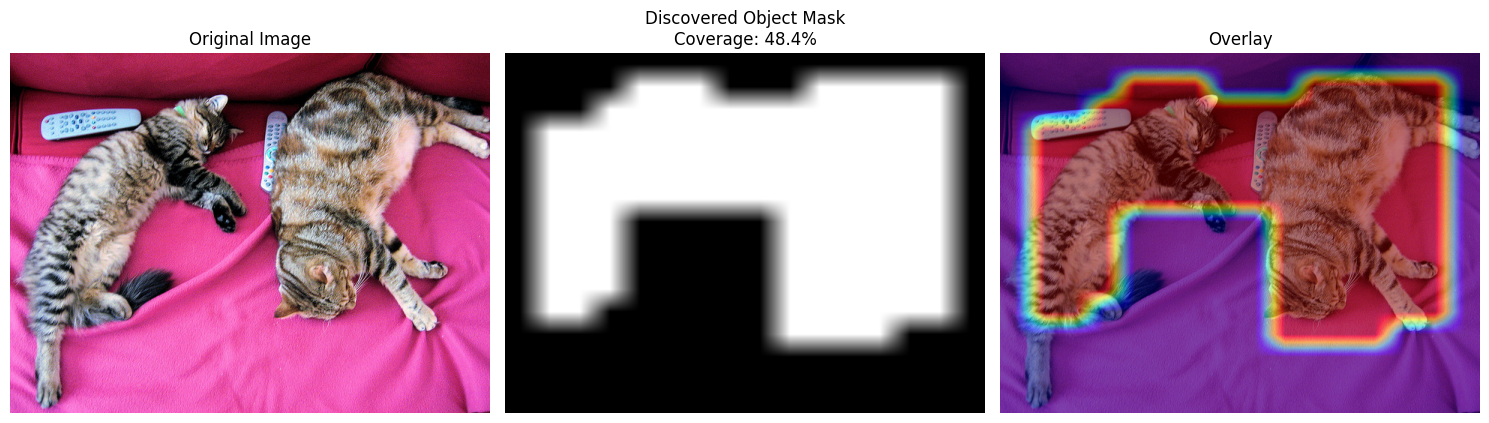


Threshold: 0.2


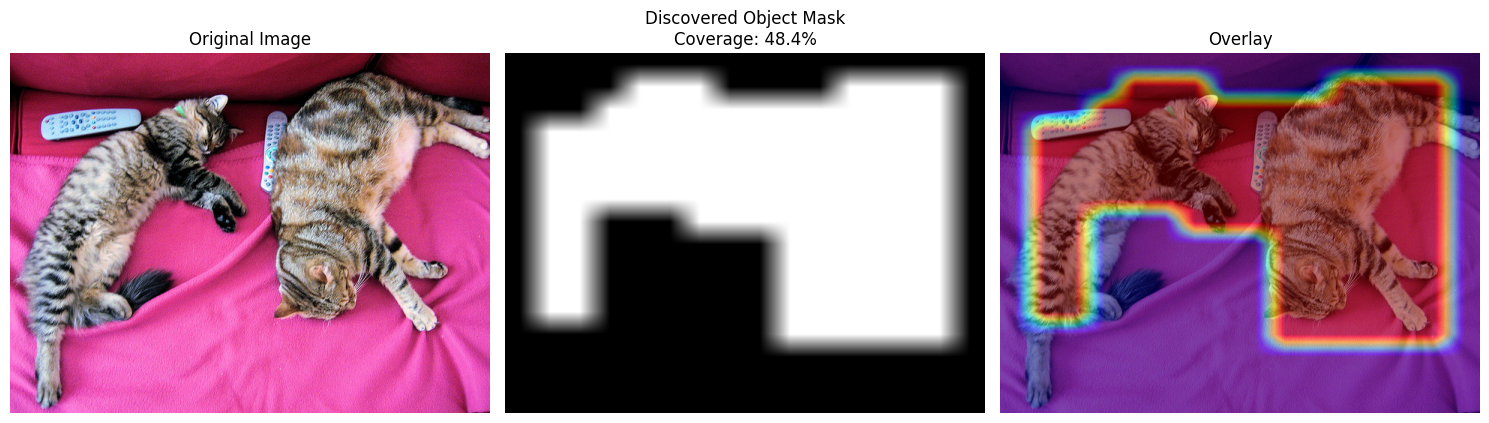


Threshold: 0.3


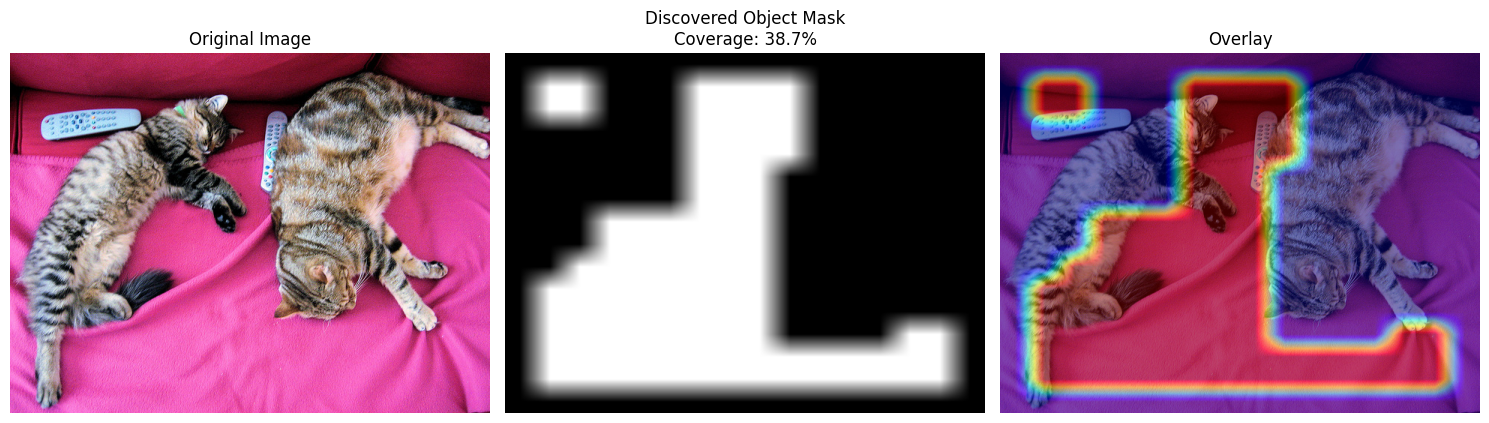

In [5]:
demo_with_example_images()

In [6]:

evaluate_on_voc(
    num_samples=100,
    model_name="facebook/dinov3-vits16-pretrain-lvd1689m",
    thresholds=[0.3])


Evaluating on VOC 2007
Model:  facebook/dinov3-vits16-pretrain-lvd1689m
Layer: -1
Adaptive thresholding: True
Post-processing: True
Loading model:  facebook/dinov3-vits16-pretrain-lvd1689m


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/86.4M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

DINOv3ViTConfig {
  "architectures": [
    "DINOv3ViTModel"
  ],
  "attention_dropout": 0.0,
  "drop_path_rate": 0.0,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_size": 384,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "key_bias": false,
  "layer_norm_eps": 1e-05,
  "layerscale_value": 1.0,
  "mlp_bias": true,
  "model_type": "dinov3_vit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "num_register_tokens": 4,
  "patch_size": 16,
  "pos_embed_jitter": null,
  "pos_embed_rescale": 2.0,
  "pos_embed_shift": null,
  "proj_bias": true,
  "query_bias": true,
  "rope_theta": 100.0,
  "transformers_version": "4.57.1",
  "use_gated_mlp": false,
  "value_bias": true
}

Model loaded on cuda with patch size 16, reg count 4

Testing threshold:  0.3


τ=0.30: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]

CorLoc:  23.00% (23/100)
Mean IoU: 0.2698

RESULTS SUMMARY
τ=0.30: CorLoc=23.00%, Mean IoU=0.2698
Best threshold: 0.30
Best CorLoc:  23.00%
Best Mean IoU:  0.2698


{0.3: {'corloc': 0.23,
  'mean_iou': np.float64(0.26984700933944816),
  'correct': 23,
  'total': 100}}